In [ ]:
import pandas as pd
import geopandas as gpd

import geopandas as gpd

from rasterio.mask import mask
from rasterio.features import shapes
import numpy as np


# Custom Functions
from functions.processing.retrieval import getSoundLocations
from functions.processing.recordings import processSingleRecording, processSingleRecordingPoint, computeChangeFrame
from functions.plotting.geo_recordings import plotSingleRecordingAnalysis, plotRecord, plotRecordWithBuffers
from functions.plotting.clc_classes import plotCLCSuperclasses, plotCLCSubclasses, plotCLCClasses, plotChangeChord, plotCLCChanges, plotChangeAnalysis

In [3]:
points = getSoundLocations("Z:\\Audio_data\\Dawn_chorus_raw_data")

In [8]:
points, dbf_df, geo_df, filtered_dfs, grouped_dfs, weighted_frames, raster_crs = processSingleRecording(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(1000))
# points, dbf_df, geo_df, filtered_dfs, grouped_dfs, weighted_frames, raster_crs = processSingleRecording(corine_dir = "C:\\Users\\mfher\\git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(72924,72925))

Loading raster.
Loaded raster successfully. 
Generated buffers.
Clipped raster to the largest buffer. 
Generating individual pixels.
Selected intersecting pixels for buffer 0.
Selected intersecting pixels for buffer 1.
Selected intersecting pixels for buffer 2.
Dropped duplicate pixels
         geometry
CODE_18          
112             6
         geometry
CODE_18          
112             6
         geometry
CODE_18          
111             2
112             8
Weighted classes:
         geometry
CODE_18          
111           2.0
112          56.0
Assigned class 112 to point 0
Generated buffers.
Clipped raster to the largest buffer. 
Generating individual pixels.
Selected intersecting pixels for buffer 0.
Selected intersecting pixels for buffer 1.
Selected intersecting pixels for buffer 2.
Dropped duplicate pixels
         geometry
CODE_18          
112             4
         geometry
CODE_18          
112             7
231             1
         geometry
CODE_18          
112      

f:\Persönliches\Git\BioOTon\functions\processing\recordings.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '112' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  points.loc[points.index==idx, 'label'] = weighted_class
f:\Persönliches\Git\BioOTon\functions\processing\recordings.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  points.loc[points.index==idx, 'close'] = close


Selected intersecting pixels for buffer 0.
Selected intersecting pixels for buffer 1.
Selected intersecting pixels for buffer 2.
Dropped duplicate pixels
         geometry
CODE_18          
112             2
231             2
         geometry
CODE_18          
112             6
231             4
         geometry
CODE_18          
112             3
231             3
Weighted classes:
         geometry
CODE_18          
112            31
231            25
Assigned class 112 to point 11
Generated buffers.
Clipped raster to the largest buffer. 
Generating individual pixels.
Selected intersecting pixels for buffer 0.
Selected intersecting pixels for buffer 1.
Selected intersecting pixels for buffer 2.
Dropped duplicate pixels
         geometry
CODE_18          
112             2
142             2
         geometry
CODE_18          
112             4
142             3
231             2
         geometry
CODE_18          
112             4
142             3
Weighted classes:
         geomet

In [ ]:
# points.to_parquet("points.parquet")

In [5]:
points, dbf_df, geo_df, joined_dfs, raster_crs = processSingleRecordingPoint(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(6350,6360))

Loading raster.
Loaded raster successfully. 
Clipped raster to the point. 
Generating individual pixel.
   value                                           geometry  Value  \
0      2  POLYGON ((4540700 2742700, 4540700 2742600, 45...      2   

        Count                      LABEL3  Red  Green  Blue CODE_18  
0  17085234.0  Discontinuous urban fabric  1.0    0.0   0.0     112  
Assigned class 112 to point 6350
Clipped raster to the point. 
Generating individual pixel.
   value                                           geometry  Value  \
0      2  POLYGON ((4538100 2739200, 4538100 2739100, 45...      2   

        Count                      LABEL3  Red  Green  Blue CODE_18  
0  17085234.0  Discontinuous urban fabric  1.0    0.0   0.0     112  
Assigned class 112 to point 6351
Clipped raster to the point. 
Generating individual pixel.
   value                                           geometry  Value  \
0      2  POLYGON ((4538100 2739200, 4538100 2739100, 45...      2   

        C

f:\Persönliches\Git\BioOTon\functions\processing\recordings.py:287: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '112' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  points.loc[points.index==idx, 'label'] = weighted_class


In [ ]:
# points.to_parquet("points_single.parquet")

f:\Persönliches\Git\BioOTon\functions\plotting\geo_recordings.py:49: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  val_frame.plot(ax=ax, legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])


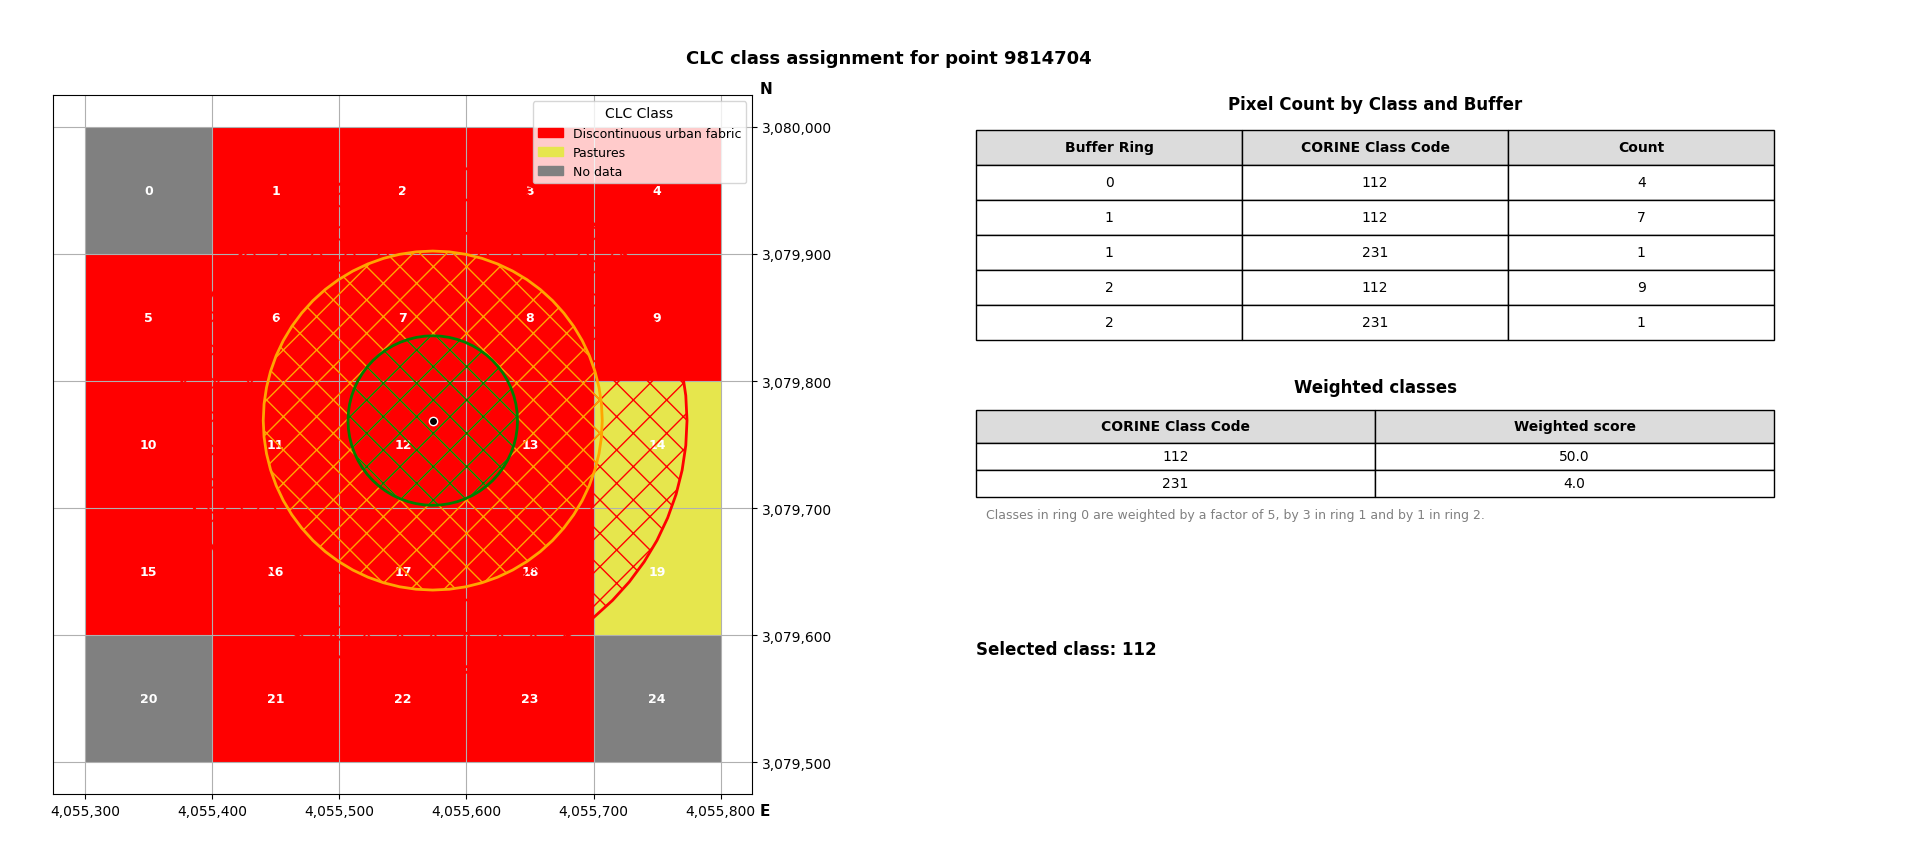

In [9]:
# Only problem with this index scheme is that the indexes are always dependent on how many points were processed previously
fig = plotSingleRecordingAnalysis(point_idx=1, dbf_frame = dbf_df, recording_frame=points, joined_frame=filtered_dfs, environment_frame=geo_df, grouped_frames = grouped_dfs, weighted_frames = weighted_frames, raster_crs=raster_crs)

In [10]:
pframe = pd.read_parquet("points.parquet")
pframe["geometry"] = gpd.GeoSeries.from_wkb(pframe.geometry).buffer(200, cap_style='square')

In [11]:
pframe_single = pd.read_parquet("points_single.parquet")
pframe_single["geometry"] = gpd.GeoSeries.from_wkb(pframe_single.geometry).buffer(200, cap_style='square')

f:\Persönliches\Git\BioOTon\functions\plotting\clc_classes.py:91: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(top=ax.get_ylim()[1] * 5)


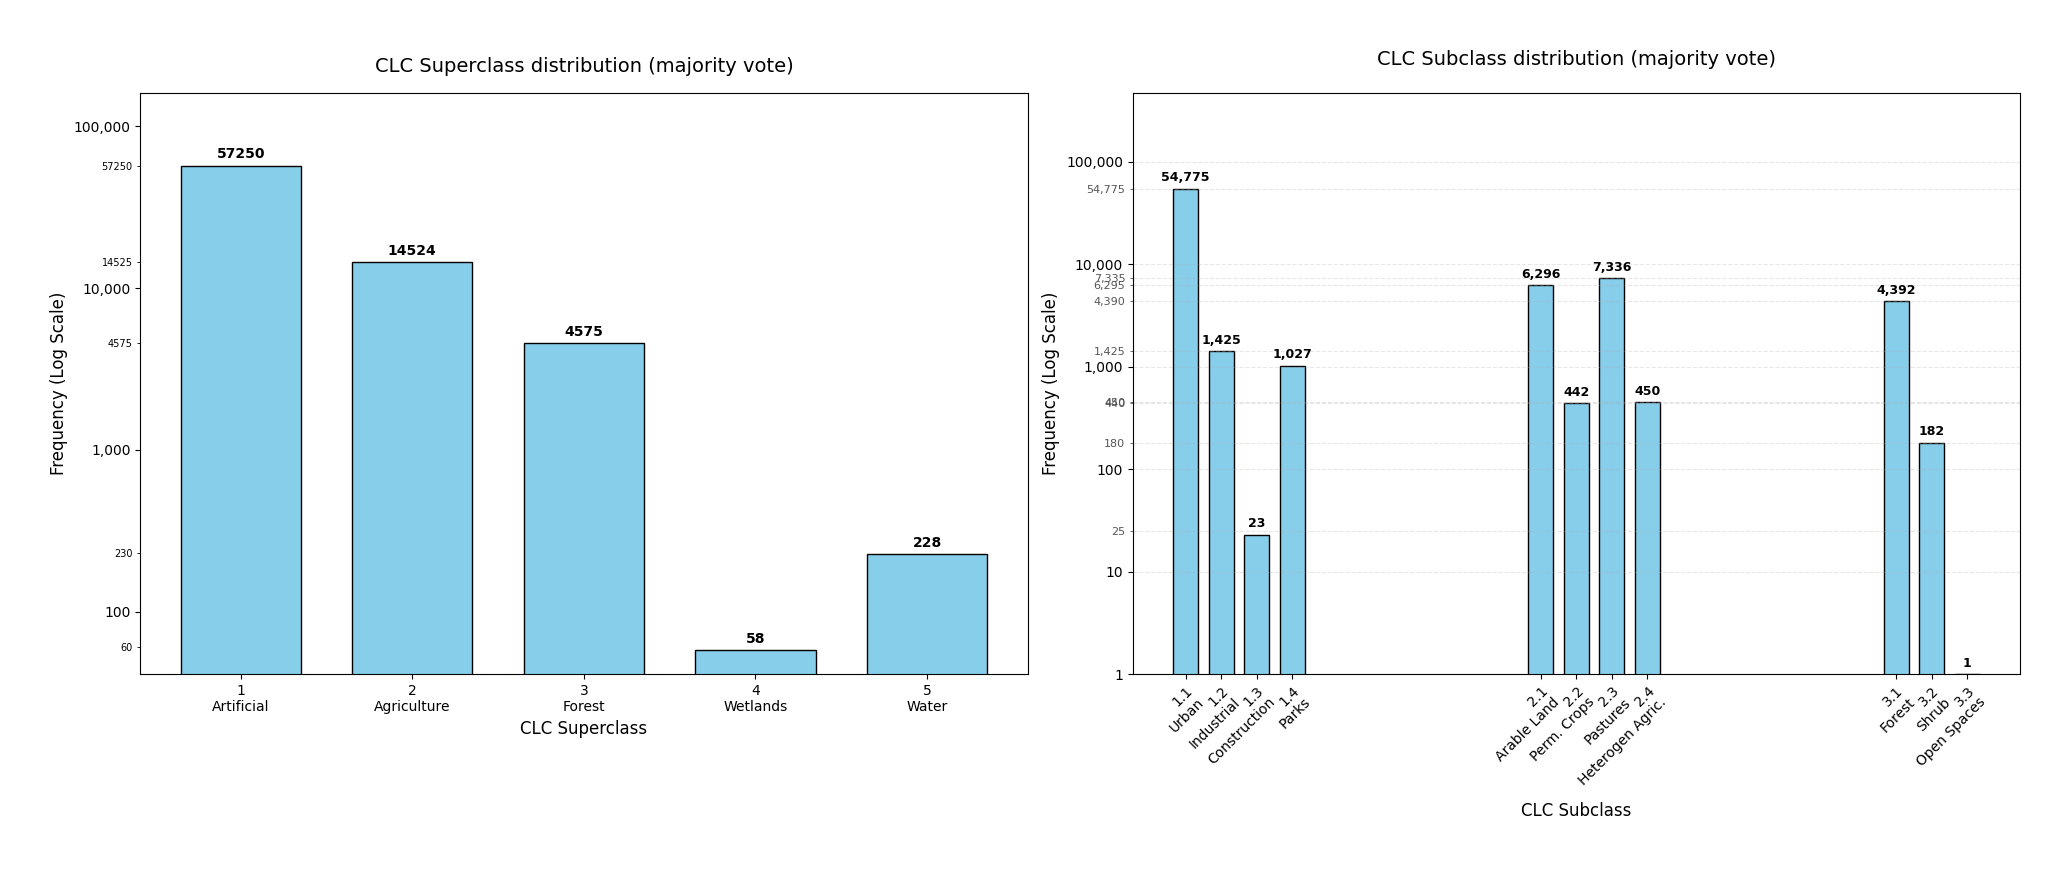

In [12]:
majority_vote = plotCLCClasses(pframe)

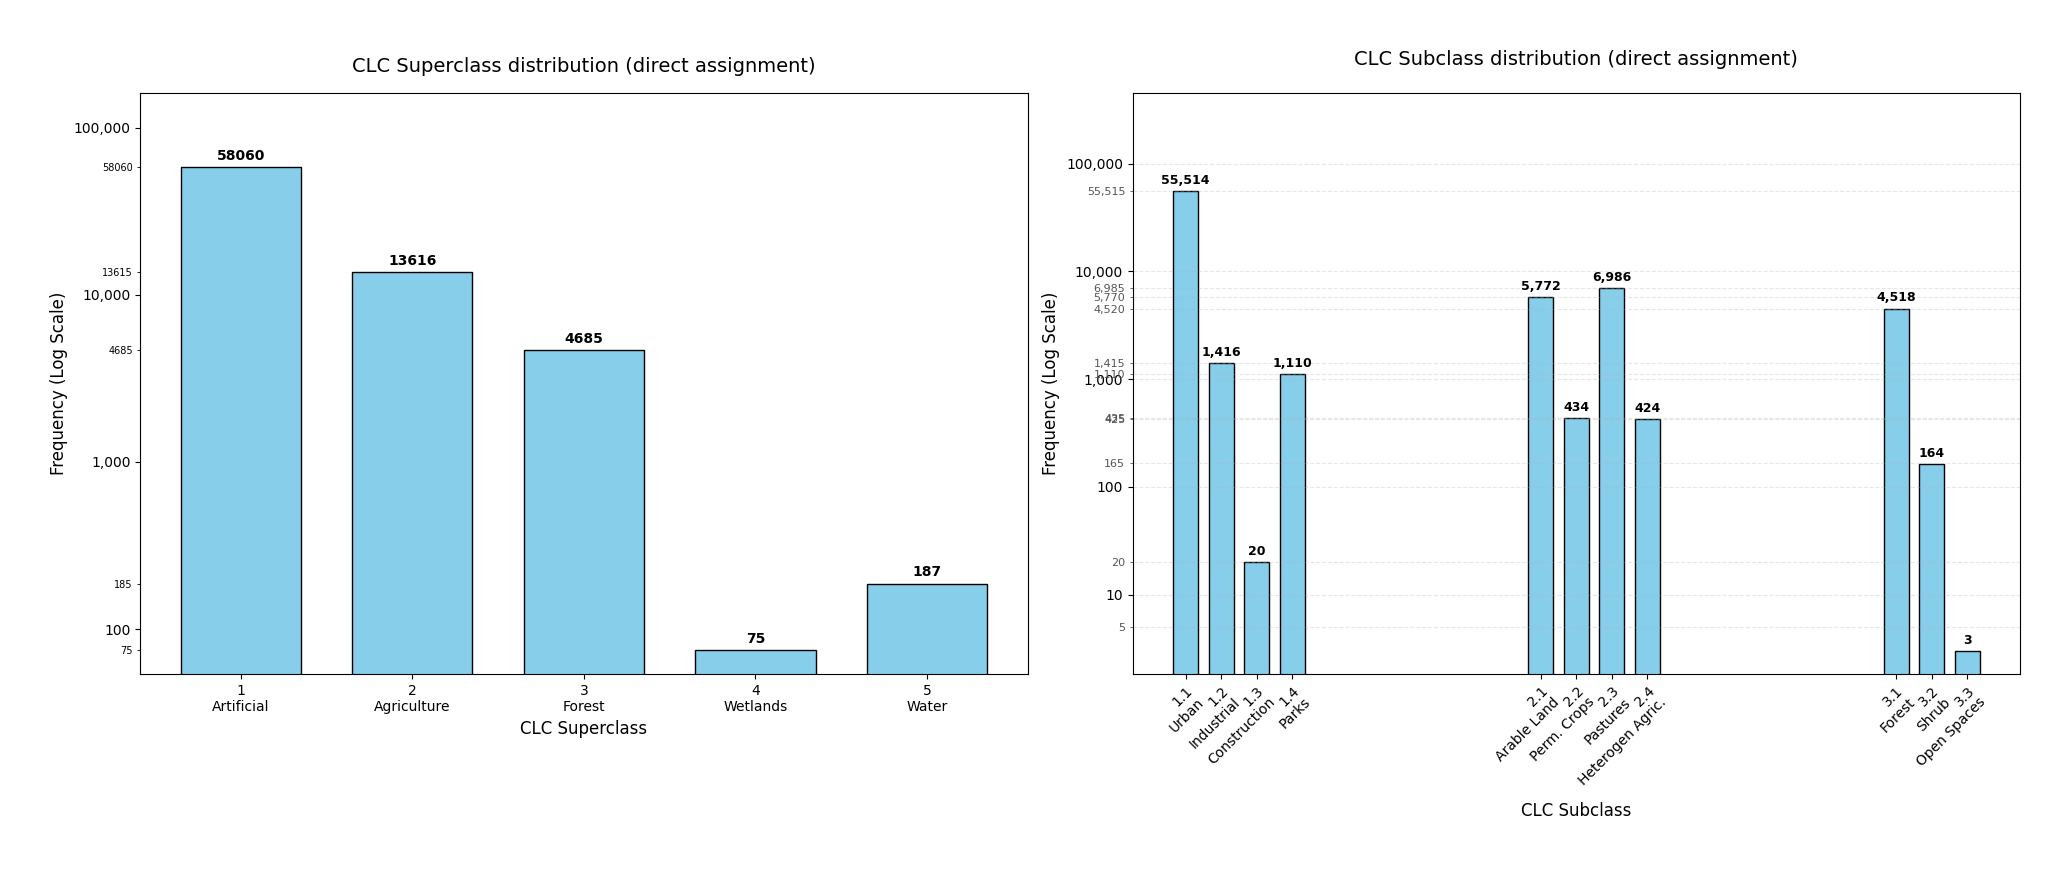

In [13]:
direct_assignment = plotCLCClasses(pframe_single, "direct assignment")

In [14]:
change_gframe = computeChangeFrame(pframe, pframe_single, raster_crs=raster_crs)

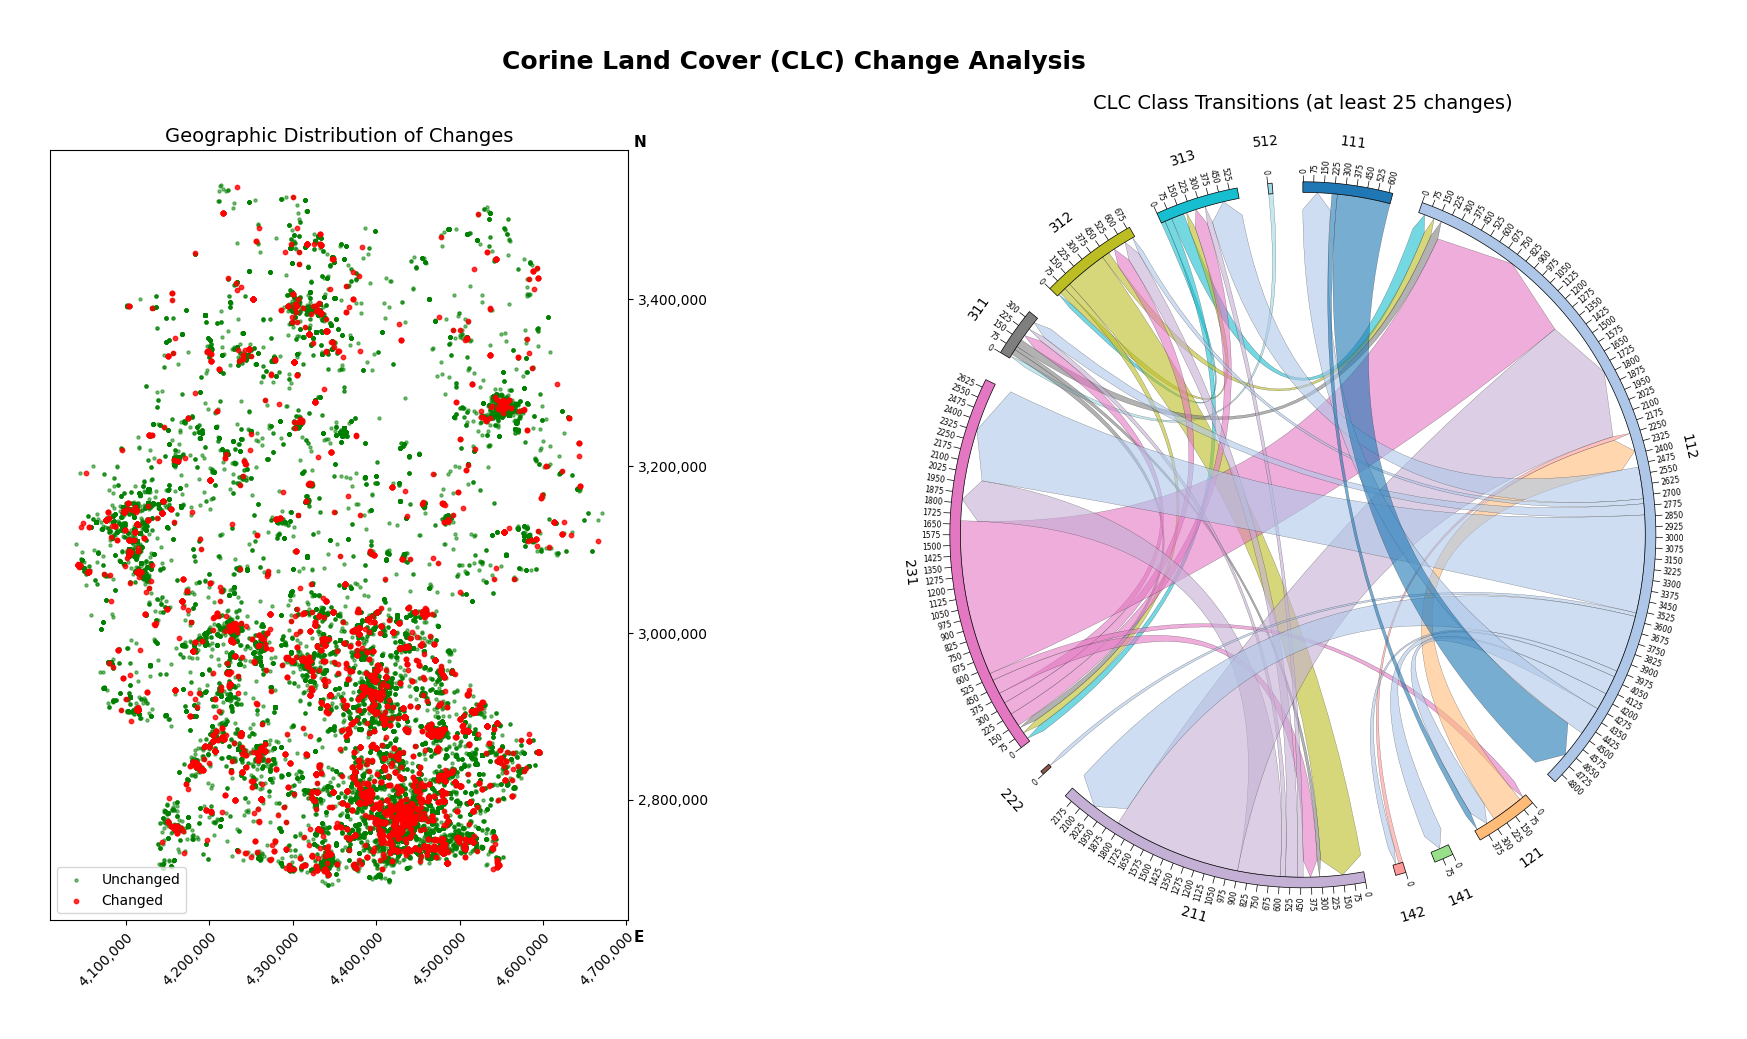

In [15]:
change_analysis = plotChangeAnalysis(change_gframe)